In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_csv("Uber-Jan-Feb-FOIL.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB


,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [3]:
df.rename(columns={
    'dispatching_base_number': 'base',
    'date': 'date',
    'active_vehicles': 'vehicles',
    'trips': 'trips'
}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

In [4]:
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

Total Uber Trips Per Day

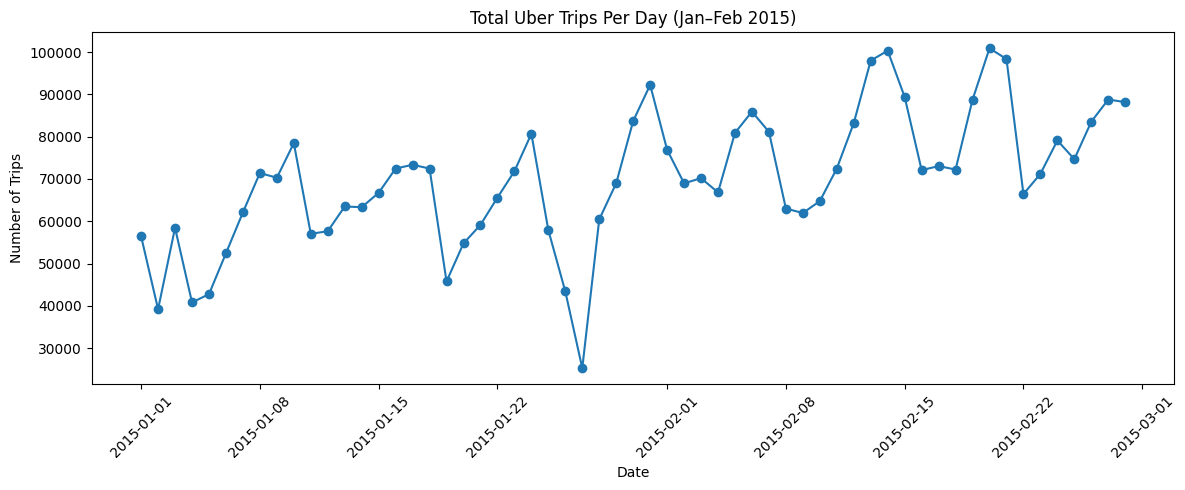

In [5]:
daily_trips = df.groupby('date')['trips'].sum()

plt.figure(figsize=(12, 5))
plt.plot(daily_trips.index, daily_trips.values, marker='o')
plt.title("Total Uber Trips Per Day (Jan–Feb 2015)")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Trips by Day of the Week

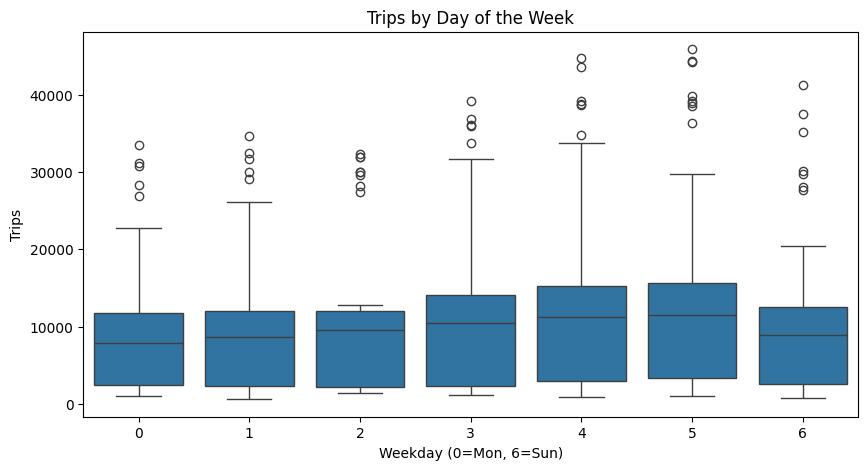

In [6]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='weekday', y='trips')
plt.title("Trips by Day of the Week")
plt.xlabel("Weekday (0=Mon, 6=Sun)")
plt.ylabel("Trips")
plt.show()

In [7]:
X = df[['vehicles', 'day', 'weekday', 'month']]
y = df['trips']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [8]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_mape = mean_absolute_percentage_error(y_test, y_pred_xgb)


In [14]:
gbtr_model = GradientBoostingRegressor(random_state=42)
gbtr_model.fit(X_train, y_train)
y_pred_gbtr = gbtr_model.predict(X_test)
gbtr_mape = mean_absolute_percentage_error(y_test, y_pred_gbtr)

In [15]:
rf_mape = mean_absolute_percentage_error(y_test, y_pred)

In [17]:
xgb_w = 1 / xgb_mape
gbtr_w = 1 / gbtr_mape
rf_w = 1 / rf_mape
w_sum = xgb_w + gbtr_w + rf_w

weights = {
    'XGB': xgb_w / w_sum,
    'GBTR': gbtr_w / w_sum,
    'RF': rf_w / w_sum
}

ensemble_pred = (weights['XGB'] * y_pred_xgb +
                 weights['GBTR'] * y_pred_gbtr +
                 weights['RF'] * y_pred)
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_pred)

In [9]:
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 1847213.5906154928
R^2 Score: 0.9852290115496173


Visualizing RandomForest

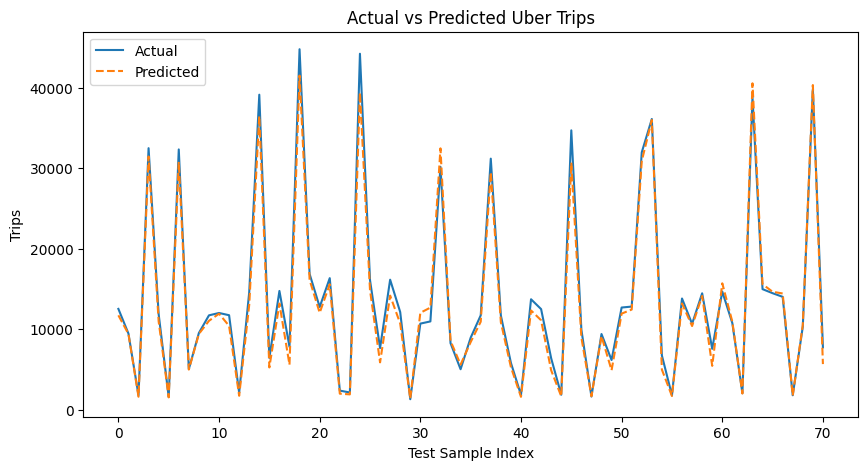

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title("Actual vs Predicted Uber Trips")
plt.xlabel("Test Sample Index")
plt.ylabel("Trips")
plt.legend()
plt.show()

 Visualizing All Model Predictions

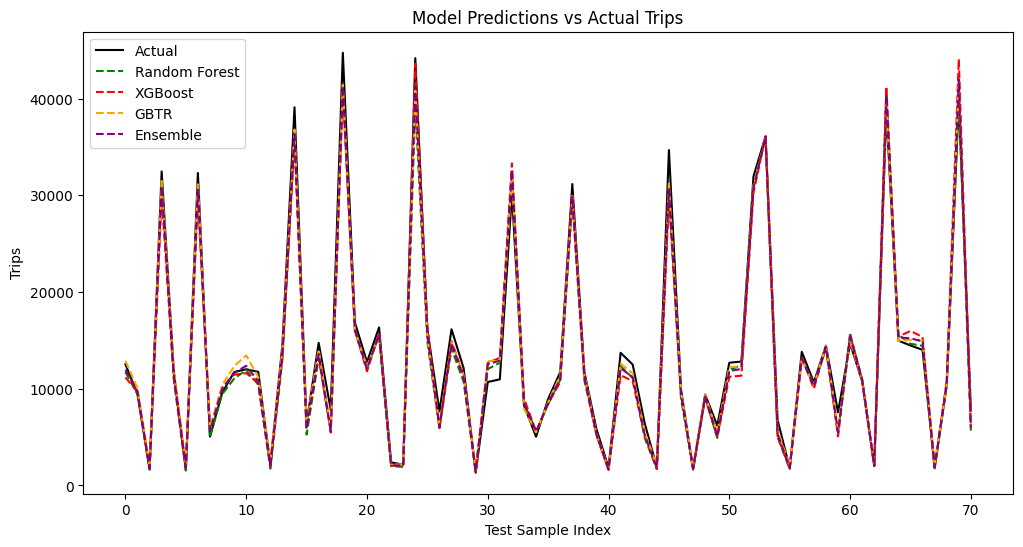

In [18]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_pred, label='Random Forest', linestyle='--', color='green')
plt.plot(y_pred_xgb, label='XGBoost', linestyle='--', color='red')
plt.plot(y_pred_gbtr, label='GBTR', linestyle='--', color='orange')
plt.plot(ensemble_pred, label='Ensemble', linestyle='--', color='purple')
plt.title("Model Predictions vs Actual Trips")
plt.xlabel("Test Sample Index")
plt.ylabel("Trips")
plt.legend()
plt.show()


In [19]:
print("\nModel Performance (MAPE):")
print(f"Random Forest: {rf_mape:.2%}")
print(f"XGBoost: {xgb_mape:.2%}")
print(f"GBTR: {gbtr_mape:.2%}")
print(f"Ensemble: {ensemble_mape:.2%}")


Model Performance (MAPE):
Random Forest: 8.51%
XGBoost: 9.07%
GBTR: 7.92%
Ensemble: 7.66%
